In [1]:
import pandas as pd 
import numpy as np
from functools import partial
from glob import glob
import matplotlib.pyplot as plt
from pymongo import MongoClient

from utils.misc import read_mongo, batch
from utils.geolocation import CachedGeolocator, region_fixer, locality_fixer, countryName_fixer, address_to_location
from utils.dk021 import DK021
from utils.etl import transform_dataset


%matplotlib inline

In [2]:
from utils.misc import mem_usg

full_df = pd.read_parquet('full.parquet.gzip')
# mem_usg(full_df)/(1024*1024)

In [3]:
full_df['month_start']=full_df['date'].dt.month.astype('object')
full_df['week_start']=full_df['date'].dt.week.astype('object')
full_df['year_start']=full_df['date'].dt.year.astype('object')
full_df['dayofweek']=full_df['date'].dt.dayofweek.astype('object')
full_df['dayofmonth']=full_df['date'].dt.day.astype('object')
full_df['quarter']=full_df['date'].dt.quarter.astype('object')

/tmp/ipykernel_3480/1801142023.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  full_df['week_start']=full_df['date'].dt.week.astype('object')


In [4]:
df_complete = full_df.loc[full_df['status'].isin(['complete','unsuccessful'])]

df_complete=df_complete[['id','month_start','week_start',
                            'year_start', 'dayofweek','dayofmonth','quarter', 
       'owner','value_valueAddedTaxIncluded',
       'procuringEntity_kind','status','procuringEntity_address',
                        'mainProcurementCategory','procurementMethod',
                        'procurementMethodType']]

df_complete['procuringEntity_address']=df_complete['procuringEntity_address'].apply(lambda x:x['locality'])
df_complete=df_complete.drop_duplicates()

df_complete.loc[(df_complete['procuringEntity_address'].isnull()),
                'procuringEntity_address']='not_indicated'
kiev_cond=(df_complete['procuringEntity_address'].str.contains('Киев|Київ'))
dnipro_cond=(df_complete['procuringEntity_address'].str.contains('Дніпро|Днепр'))
kharkiv_cond=(df_complete['procuringEntity_address'].str.contains('Харків|Харьков'))
lviv_cond=(df_complete['procuringEntity_address'].str.contains('Львів|Львов'))
odesa_cond=(df_complete['procuringEntity_address'].str.contains('Одеса|Одесса'))
marik_cond=(df_complete['procuringEntity_address'].str.contains('Маріуполь|Мариуполь'))

df_complete.loc[((kiev_cond)),'procuringEntity_address'] = 'Київ'
df_complete.loc[((dnipro_cond)),'procuringEntity_address'] = 'Дніпро'
df_complete.loc[((kharkiv_cond)),'procuringEntity_address'] = 'Харків'
df_complete.loc[((lviv_cond)),'procuringEntity_address'] = 'Львів'
df_complete.loc[((odesa_cond)),'procuringEntity_address'] = 'Одеса'
df_complete.loc[((marik_cond)),'procuringEntity_address'] = 'Маріуполь'
df_complete.loc[~((kiev_cond)|(dnipro_cond)|(kharkiv_cond)|
     (lviv_cond)|(odesa_cond)|(marik_cond)),'procuringEntity_address'] = 'Інші'

In [5]:
df_complete['status'] = df_complete['status'].map({'complete':1,'unsuccessful':0})

In [6]:
new = df_complete.sample(frac=0.5)

In [7]:
X=new.drop(['status'],axis=1).copy()
y=new['status'].copy()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_auc_score, accuracy_score, f1_score, precision_score, balanced_accuracy_score

In [9]:
med_val=full_df.groupby('id')['value_amount'].median().reset_index().rename({'value_amount':'med'},axis='columns')
max_val=full_df.groupby('id')['value_amount'].max().reset_index().rename({'value_amount':'max'},axis='columns')
min_val=full_df.groupby('id')['value_amount'].min().reset_index().rename({'value_amount':'min'},axis='columns')
lot_val=full_df.groupby('id')['lots_id'].count().reset_index().rename({'lots_id':'lot_count'},axis='columns')
l1_val=full_df.groupby('id')['items_classification_l1'].count().reset_index().rename({'items_classification_l1':'count_l1'},axis='columns')
l2_val=full_df.groupby('id')['items_classification_l2'].count().reset_index().rename({'items_classification_l2':'count_l2'},axis='columns')
l3_val=full_df.groupby('id')['items_classification_l3'].count().reset_index().rename({'items_classification_l3':'count_l3'},axis='columns')

In [10]:
doo=full_df.groupby('id')['items_classification_l1'].agg(pd.Series.mode)
doo = doo.reset_index()

In [11]:
doo2=full_df.groupby('id')['items_classification_l2'].agg(pd.Series.mode)
doo2=doo2.reset_index()

In [85]:
doo3=full_df.groupby('id')['items_classification_l3'].agg(pd.Series.mode)
doo3=doo3.reset_index()

In [12]:
X = X.merge(med_val,on='id',how='inner')
X = X.merge(max_val,on='id',how='inner')
X = X.merge(min_val,on='id',how='inner')
X = X.merge(lot_val,on='id',how='inner')
X = X.merge(l1_val,on='id',how='inner')
X = X.merge(l2_val,on='id',how='inner')
X = X.merge(l3_val,on='id',how='inner')

In [13]:
X = X.merge(doo,on='id',how='inner')
X = X.merge(doo2,on='id',how='inner')

In [14]:
X['owner'] = X['owner'].astype('object') 
X['procuringEntity_kind'] = X['procuringEntity_kind'].astype('object') 
X['procuringEntity_address'] = X['procuringEntity_address'].astype('object') 
X['mainProcurementCategory'] = X['mainProcurementCategory'].astype('object') 
X['procurementMethod'] = X['procurementMethod'].astype('object') 
X['procurementMethodType'] = X['procurementMethodType'].astype('object') 
# X['items_classification_l3'] = X['items_classification_l3'].astype('object') 

In [15]:
X = X.drop('id',axis=1)

In [17]:
X.head()

,month_start,week_start,year_start,dayofweek,dayofmonth,quarter,owner,value_valueAddedTaxIncluded,procuringEntity_kind,procuringEntity_address,...,procurementMethodType,med,max,min,lot_count,count_l1,count_l2,count_l3,items_classification_l1,items_classification_l2
0,8.0,33.0,2021.0,2.0,18.0,3.0,it.ua,True,special,Київ,...,belowThreshold,124716.0,124716.0,124716.0,2,2,2,2,18000000-9,18300000-2
1,3.0,12.0,2021.0,1.0,23.0,1.0,netcast.com.ua,True,general,Київ,...,aboveThresholdEU,7500000.0,7500000.0,7500000.0,4,4,4,4,31000000-6,31600000-2
2,10.0,43.0,2021.0,0.0,25.0,4.0,netcast.com.ua,True,general,Інші,...,aboveThresholdUA,486000.0,486000.0,486000.0,2,2,2,2,30000000-9,30200000-1
3,7.0,26.0,2021.0,4.0,2.0,3.0,it.ua,False,special,Київ,...,aboveThresholdUA,486150.0,486150.0,486150.0,3,3,3,3,77000000-0,77300000-3
4,4.0,15.0,2021.0,2.0,14.0,2.0,e-tender.biz,True,general,Львів,...,belowThreshold,150010.8,150010.8,150010.8,2,2,2,2,15000000-8,15800000-6


In [22]:
X.to_parquet('X.parquet.gzip',compression='gzip') 

In [16]:
y.to_frame().to_parquet('y.parquet.gzip',compression='gzip') 

In [3]:
X = pd.read_parquet('X.parquet.gzip')

In [7]:
y = pd.read_parquet('y.parquet.gzip')

In [16]:
X = pd.get_dummies(X,drop_first=True,sparse=True)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [19]:
copy_X_train=X_train.copy()
copy_X_train['y']=y_train.values
copy_X_test=X_test.copy()
copy_X_test['y']=y_test.values

/tmp/ipykernel_3480/2814977569.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_X_train['y']=y_train.values
/tmp/ipykernel_3480/2814977569.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_X_test['y']=y_test.values


In [24]:
import pandas as pd

In [34]:
model = RandomForestClassifier(n_estimators=150,random_state=42,
                               n_jobs=-1,max_depth=20)

In [35]:
# pipeline = Pipeline([('reg', model)])
model.fit(X_train,y_train)

/home/nalexus/dsrl2/prozorro/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


RandomForestClassifier(max_depth=20, n_estimators=150, n_jobs=-1,
                       random_state=42)

In [43]:
import pickle

In [44]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [36]:
y_pred = model.predict(X_test)

/home/nalexus/dsrl2/prozorro/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [37]:
print('true:')
print(y_test.value_counts(normalize=True))
print('pred:')
print(pd.Series(y_pred).value_counts(normalize=True))

true:
1.0    0.661893
0.0    0.338107
Name: status, dtype: float64
pred:
1.0    0.775194
0.0    0.224806
dtype: float64


In [38]:
accuracy_score(y_test,y_pred)

0.8421465855190488

In [39]:
balanced_accuracy_score(y_test,y_pred)

0.7826777339984139

In [40]:
f1_score(y_test,y_pred)

0.8901573809281594

In [41]:
precision_score(y_test,y_pred)

0.8251051227246693

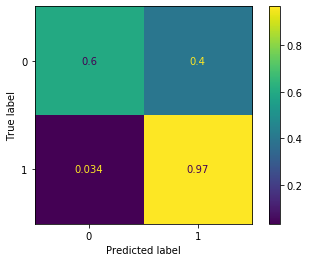

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred,normalize='true')

cm_display = ConfusionMatrixDisplay(cm).plot()

This is from unconstrained max depth:

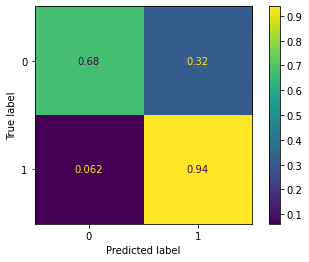

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred,normalize='true')

cm_display = ConfusionMatrixDisplay(cm).plot()

In [47]:
y_pred = model.predict_proba(X_test)

/home/nalexus/dsrl2/prozorro/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [39]:
roc_auc_score(y_test, y_pred[:,1])

0.9158296214139963

In [63]:
feature_names = [col for col in X_train.columns]

In [65]:
importances=model.feature_importances_

In [66]:
forest_importances = pd.Series(importances, index=feature_names)

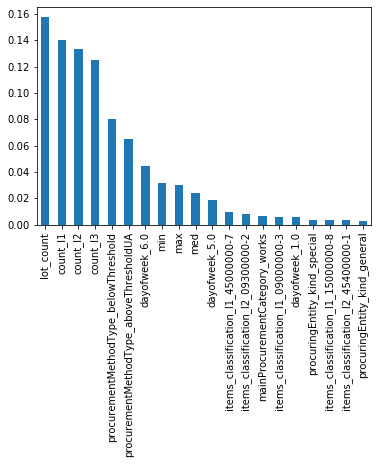

In [73]:
forest_importances.round(5).sort_values(ascending=False)[:20].plot(kind='bar')
plt.show()

In [35]:
from sklearn.inspection import PartialDependenceDisplay

In [49]:
# X_train.sample(1000).to_csv('train.csv',index=False)

In [61]:
# X_train.columns

Index(['value_valueAddedTaxIncluded', 'med', 'max', 'min', 'lot_count',
       'count_l1', 'count_l2', 'count_l3', 'month_start_2.0',
       'month_start_3.0',
       ...
       'items_classification_l2_92300000-4',
       'items_classification_l2_92400000-5',
       'items_classification_l2_92500000-6',
       'items_classification_l2_92600000-7',
       'items_classification_l2_98000000-3',
       'items_classification_l2_98100000-4',
       'items_classification_l2_98300000-6',
       'items_classification_l2_98500000-8',
       'items_classification_l2_98900000-2',
       'items_classification_l2_99999999-9'],
      dtype='object', length=501)

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [90]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

Computing partial dependence plots...


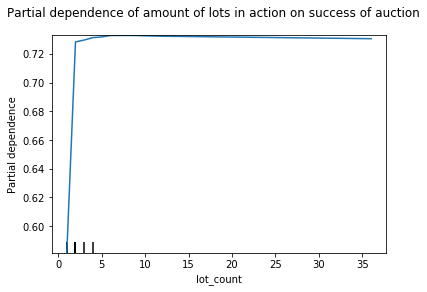

In [91]:

print("Computing partial dependence plots...")
features = ['lot_count']
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train.sample(1000),
    features,
    kind="average",
    subsample=100,
    n_jobs=1,
    random_state=0
)

display.figure_.suptitle(
    "Partial dependence of amount of lots in action on success of auction"
)
display.figure_.subplots_adjust(hspace=0.3)
plt.show()

Computing partial dependence plots...


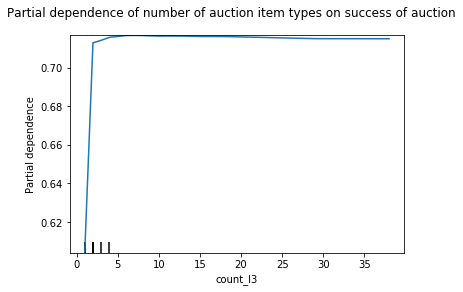

In [92]:

print("Computing partial dependence plots...")
features = ['count_l3']
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train.sample(1000),
    features,
    kind="average",
    subsample=100,
    n_jobs=1,
    random_state=0
)

display.figure_.suptitle(
    "Partial dependence of number of auction item types on success of auction"
)
display.figure_.subplots_adjust(hspace=0.3)
plt.show()

Computing partial dependence plots...


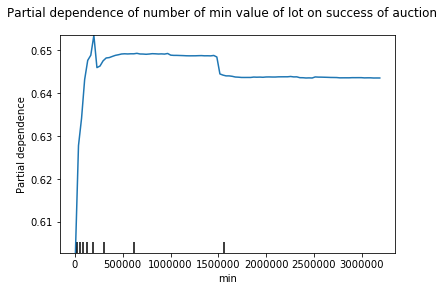

In [94]:
print("Computing partial dependence plots...")
features = ['min']
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train.sample(1000),
    features,
    kind="average",
    subsample=100,
    n_jobs=1,
    random_state=0
)

display.figure_.suptitle(
    "Partial dependence of number of min value of lot on success of auction"
)
display.figure_.subplots_adjust(hspace=0.3)
plt.show()

**Conclusion**:

- The bigger is the minimal lot value in auction the bigger is chance of its success, but after some point this effect does not continue

- The bigger is amount of variation of item types in acution the bigger is chance of its success , but after some point this effect does not continue.

- The bigger is amount of lots in acution the bigger is chance of its success , but after some point this effect does not continue.